In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from matplotlib.dates import date2num, num2date
import datetime as dt
import pickle
from pycurrents.num import runstats as rs
from oyv.imports import *

In [2]:
basedir = '/home/oyvindl/work/projects/barents_glaciers/glacierocean-austfonna/data/glacier_fronts/'
ddir_in = basedir + 'excel_from_josephine/'
ddir_out = basedir + 'python/'

#### Load Josephine's excel sheets

- Confirmed that this is the difference between sucessice photos in meters (area change divided by length)
- I manually changed what I think is a typo in the time field 

In [8]:
%matplotlib inline

In [3]:
readkeys = {'parse_dates':False,  
           'date_parser':lambda x: pd.to_datetime(x).strftime("%d.%m.%y")}

In [4]:
d_austf = pd.read_excel(ddir_in + 'austfonna_advR.xlsx', **readkeys)
d_sh = pd.read_excel(ddir_in + 'SH_advR_ØLmod.xlsx', **readkeys)

#### Read all austfonna: *d_austf*
- Contains rates for 19 fronts on Austfonna between 06.10.2016 and 04.09.2021 (time resoution about monthly)


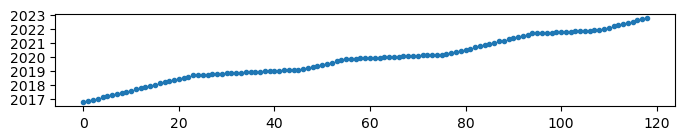

In [9]:
fig, ax = plt.subplots(figsize = (8, 1.2))
ax.plot(d_sh.time, '.')

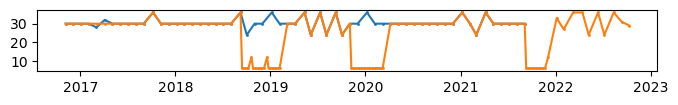

In [10]:
fig, ax = plt.subplots(figsize = (8, 0.8))
ax.plot(d_austf.time[1:], np.diff(date2num(d_austf.time)), '.-', ms = 2)
ax.plot(d_sh.time[1:], np.diff(date2num(d_sh.time)), '.-', ms = 2)

In [11]:
DAF = dict()
sort_ind = np.argsort(date2num(d_austf.time))
time_diff_austf = (date2num(d_austf.time.to_numpy()[sort_ind][1:]) 
                 - date2num(d_austf.time.to_numpy()[sort_ind][:-1]))
DAF['time'] = num2date(date2num(d_austf.time.to_numpy()[sort_ind][:-1]) + time_diff_austf/2)
glaciers_af = list(d_austf.columns)
glaciers_af.remove('time')

for glacier in glaciers_af:
    DAF[glacier] = d_austf[glacier].to_numpy()[sort_ind][1:]/time_diff_austf

#### Read all Storisstraumen/Hartogbukta *d_sh*
- Contains rates for hartogbukta and Storisstraumen fronts on Austfonna between 06.10.2016 and 21.11.2021 (time resoution varies from about monthly)

In [12]:
DSH = dict()
sort_ind = np.argsort(date2num(d_sh.time))
time_diff_sh = (date2num(d_sh.time.to_numpy()[sort_ind][1:]) 
              - date2num(d_sh.time.to_numpy()[sort_ind][:-1]))
DSH['time'] = num2date(date2num(d_sh.time.to_numpy()[sort_ind][:-1]) + time_diff_sh/2)
glaciers_sh = list(d_sh.columns)
glaciers_sh.remove('time')

for glacier in glaciers_sh:
    DSH[glacier] = d_sh[glacier].to_numpy()[sort_ind][1:]/time_diff_sh

### NEW SS/HB (combination)

Don't want the high-frequency stuff (want a uniform time series only for now) 

Using the AF data and appending three points from the *SH_advR* sheet (calculated cumulative rate independently elsewhere) 

(-1.0, 2.0)

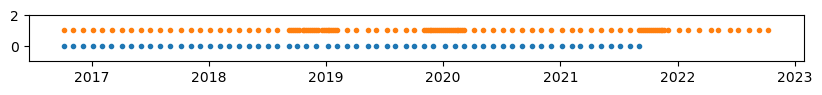

In [13]:
fig, ax = plt.subplots(figsize = (10, 0.6))
ax.plot(d_austf.time, d_austf.index*0,'.')
ax.plot(d_sh.time, d_sh.index*0+1,'.')
ax.set_ylim(-1, 2)

In [14]:
ca()

In [53]:
# INTERPOLATE CUMULATED

SS_CS_i_interpolant = interp1d(date2num(d_sh.time), np.cumsum(d_sh.Storisstraumen))
ti = np.arange(date2num(d_sh.time)[0], date2num(d_sh.time)[-1]+1)
SS_CS_i = SS_CS_i_interpolant(ti)


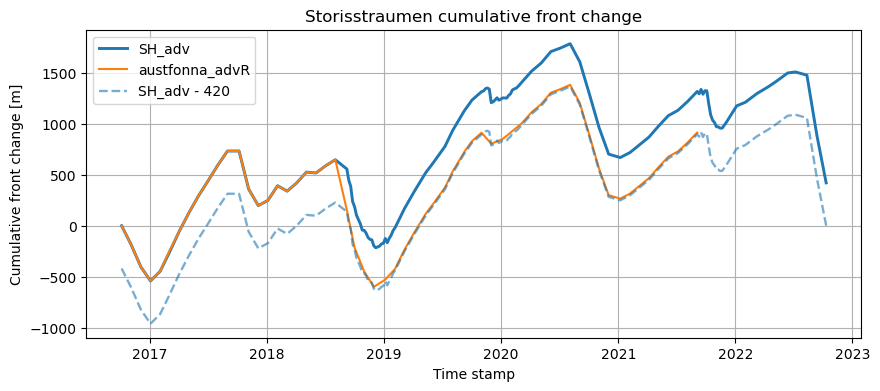

In [80]:
fig, ax = plt.subplots(figsize = (10, 4))
ax.plot(d_sh.time, np.cumsum(d_sh.Storisstraumen), label = 'SH_adv', lw = 2.1)
ax.plot(d_austf.time, np.cumsum(d_austf.Storisstraumen), label = 'austfonna_advR', zorder = 2)
ax.plot(d_sh.time, np.cumsum(d_sh.Storisstraumen)-420, '--', color = col.col('b'), 
        label = 'SH_adv - 420', lw = 1.7, alpha = 0.6)
#ax.plot(ti, SS_CS_i, ':', color = col.col('k'), 
#        label = 'Interpolated', lw = 1.7, alpha = 0.6)
#ax.plot(ti, rs(SS_CS_i, runs_days).mean, '-.', color = col.col('y'), 
#        label = 'Interpolated, smoothed', lw = 1.7, alpha = 0.6)
ax.set_xlabel('Time stamp')
ax.set_ylabel('Cumulative front change [m]')
ax.set_title('Storisstraumen cumulative front change')

ax.legend()
ax.grid()

#ax.set_xlim(dt.date(2019, 11, 1), dt.date(2020, 1, 31))
fig.savefig('SHadv_vs_austfonna_advrate.png')

In [64]:
ca()

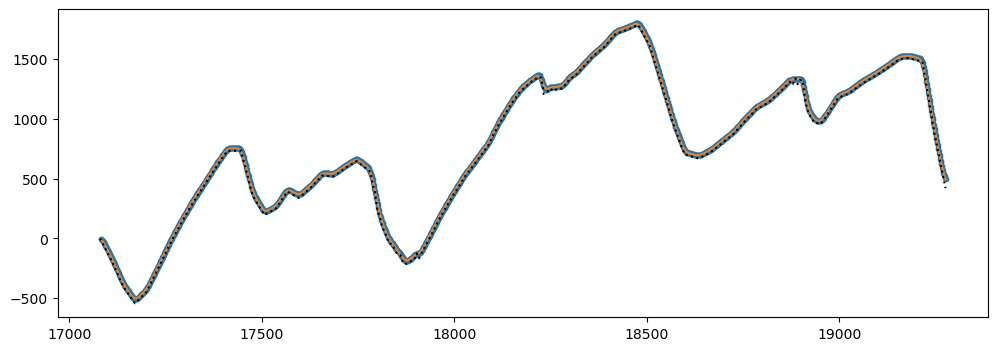

In [66]:
## Further check of low pass filter on cumulative

fig, ax = plt.subplots(figsize =(12, 4))
ax.plot(ti_mid, np.cumsum(SS_i), '.')
ax.plot(ti_mid, np.cumsum(rs(SS_i, 15).mean), '-')
ax.plot(ti, SS_CS_i, ':k')

In [68]:
# SMOOTHING AND DIFFERENTIATING
runs_days = 15
SS_i = np.diff(rs(SS_CS_i, runs_days).mean)
ti_mid = ti[1:]+0.5

DOUT_SSHB = dict(time=num2date(ti[1:]-0.5), )
DOUT_SSHB['storis'] = SS_i

### Plot

Check consistency + that the monthly downscaling works

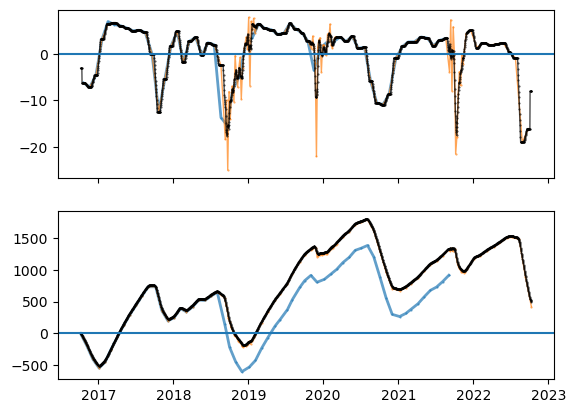

In [74]:
fig, ax = plt.subplots(2, 1, sharex = True)
#ax.plot(d_sh.time, d_sh.Storisstraumen)
#ax.plot(d_af.time, d_af.Storisstraumen)
ax[0].plot(DAF['time'], DAF['Storisstraumen'], '.-', alpha = 0.7, ms = 1,lw = 2)
ax[0].plot(DSH['time'], DSH['Storisstraumen'], '.-', alpha = 0.7, ms = 1,lw = 1)
ax[0].plot(DOUT_SSHB['time'], DOUT_SSHB['storis'], '.-k', alpha = 0.7, ms = 1,lw = 1)
ax[0].axhline(0)



ax[1].plot(d_austf.time, np.cumsum(d_austf.Storisstraumen), '.-', alpha = 0.7, ms = 1,lw = 2)
ax[1].plot(d_sh.time, np.cumsum(d_sh.Storisstraumen), '.-', alpha = 0.7, ms = 1,lw = 1)
ax[1].plot(DOUT_SSHB['time'], np.cumsum(DOUT_SSHB['storis']), '.-k', alpha = 0.7, ms = 1,lw = 1)
ax[1].axhline(0)
#ax.plot(tmid_ss, rate_ss, '.-', alpha = 0.7, ms = 1,lw = 1)

### Add some metadata and save the HB/SS data

In [ ]:
DOUT_SSHB['meta'] = ('%s: Data from Josephine M - Hartogbukta & storisstraumen. \nSource: %s'%(
    dt.datetime.now().strftime('%d.%m.%y'), ddir_in ) + 
    'Units: meters per day. Advance is positive, retreat is negative. '
    '\n\nØyvind fixed what I think is a typo in the time field (check!?).'
     '\nØyvind added on 3 culumative points at the end (see source script).')

DOUT_SSHB['source_script'] = 'Read advance rate data.ipynb'

In [ ]:
with open(ddir_out + 'SS_HB_ADVRATES.p', 'wb') as f:
    pickle.dump(DOUT_SSHB, f)

### Save the AD data

In [75]:
DOUT_ALL = dict(DAF)

In [76]:
north = ['Fonndalsbreen', 'Duvebreen', 'Schweigaardbreen', 'Nilsenbreen', 'Leighbreen']
east = ['Worsleybreen', 'Austfonna basin-8', 'Austfonna basin-7',
       'Austfonna basin-6 (21105)', 'Austfonna basin-6 (21106)', 'Hartogbukta', 'Storisstraumen']
south = ['Klerckbukta', 'Kervelbukta', 'Braasvellbreen']
west = ['Palanderbreen', 'Ericabreen', 'Palanderisen', 'Etonbreen']

In [77]:
DOUT_ALL['glacier_sorting'] = dict(
    north = north, east = east, 
    west = west, south = south)

In [78]:
DOUT_ALL['meta'] = ('%s: Data from Josephine M- All Nordaustlandet glaciers. \nSource: %s'%(
    dt.datetime.now().strftime('%d.%m.%y'), ddir_in ) + 
    'Units: meters per day. Advance is positive, retreat is negative. '
    '\n\nØyvind fixed what I think is a typo in the time field (check!?).'
     '\nØyvind added a sorting of which glaciers are where ("glacier_sorting" field).'   )

DOUT_ALL['source_script'] = 'Read advance rate data.ipynb'

In [79]:
with open(ddir_out + 'NORDAUSTLANDET_ADVRATES.p', 'wb') as f:
    pickle.dump(DOUT_ALL, f)